In [1]:
import pennylane as qml
import pennylane.numpy as np
import jax.numpy as jnp
from scipy.special import legendre
import jax
import optax

from time import time
import pickle

import matplotlib.pyplot as plt


import os, sys, argparse

parent = os.path.abspath('../src')
sys.path.insert(1, parent)

from perceptron import NativePerceptron



# Set to float64 precision and remove jax CPU/GPU warning
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")


In [2]:

def get_loss_function(perceptron, ts, H_obj, dev):

    @jax.jit
    @qml.qnode(dev, interface="jax")
    def loss(param_vector):

        # hamitlonian_params = dictionary_to_hamiltonian_parameters(params_dict)

        param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

        qml.evolve(perceptron.H)(param_list, ts)

        return qml.expval(H_obj)

    return loss


In [3]:

# setting up the problem
perceptron_qubits = 3
pulse_basis = 2
ts = jnp.array([0.0, 1.0])

dev = qml.device("default.qubit.jax", wires = perceptron_qubits)

perceptron = NativePerceptron(perceptron_qubits, pulse_basis, basis='gaussian', pulse_width=0.5e-2)

H =  perceptron.H

H_obj, H_obj_spectrum = perceptron.get_1d_ising_hamiltonian(0.1)

e_ground_state_exact = H_obj_spectrum[0]

print(f'Ising Model Hamiltonian:\nH = {H_obj}')
print(f'Exact ground state energy: {e_ground_state_exact}')


Ising Model Hamiltonian:
H =   (0.1) [X0]
+ (0.1) [X1]
+ (0.1) [X2]
+ (1.0) [Z0 Z1]
+ (1.0) [Z1 Z2]
Exact ground state energy: -2.013499645210101


I0000 00:00:1706252242.297242       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
/Users/jorgegarciaponce/Research/Yelin/PerceptronLossLandscapes/.venv/lib/python3.11/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


In [4]:
# getting the loss_function
loss = get_loss_function(perceptron, ts, H_obj, dev)

param_vector = perceptron.get_random_parameter_vector(0)

print(f'Initial parameters: {param_vector}')

print(f'Initial loss: {loss(param_vector)}')

initial_gradients = jax.grad(loss)(param_vector)
print(f'Initial gradients: {initial_gradients}')

value_and_grad = jax.jit(jax.value_and_grad(loss))

Initial parameters: [0.64339171 0.18188521 0.02240467 0.56378114 0.55264013 0.09587247
 0.34253018 0.0364437  0.08744547 0.79091052 0.35205451 0.53364213]
Initial loss: 0.3867923751333893
Initial gradients: [ 0.56775126  0.59961299 -0.06901876  0.65400242  0.22559678  0.27371626
  0.31036057  0.38570974  1.07044752  0.96668184  0.36368276  0.3256571 ]


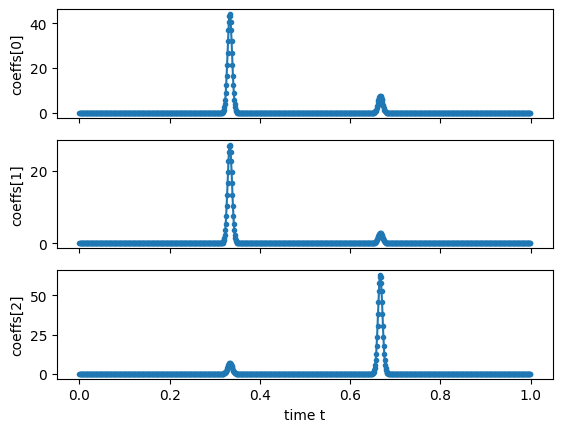

In [5]:
ts = jnp.linspace(0.0, 1, 1000)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, sharex=True)
for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-")
    ax.set_ylabel(f"coeffs[{i}]")
ax.set_xlabel("time t")
plt.show()


In [6]:

from datetime import datetime

n_epochs = 400
param_vector = perceptron.get_random_parameter_vector(8098)


# The following block creates a constant schedule of the learning rate
# that increases from 0.1 to 0.5 after 10 epochs
schedule0 = optax.constant_schedule(1)
schedule1 = optax.constant_schedule(0.1)
schedule = optax.join_schedules([schedule0, schedule1], [50])
optimizer = optax.adam(learning_rate=schedule)
# optimizer = optax.adam(learning_rate=1)
opt_state = optimizer.init(param_vector)

energies = np.zeros(n_epochs )
# energy[0] = loss(param_vector)
mean_gradients = np.zeros(n_epochs)

gradients_trajectory = []
param_trajectory = []

## Compile the evaluation and gradient function and report compilation time
time0 = time()
_ = value_and_grad(param_vector)
time1 = time()

# print(f"grad and val compilation time: {time1 - time0}")


## Optimization loop
for n in range(n_epochs):
    val, grads = value_and_grad(param_vector)
    updates, opt_state = optimizer.update(grads, opt_state)

    mean_gradients[n] = np.mean(np.abs(grads))
    energies[n] = val
    param_trajectory.append(param_vector)
    gradients_trajectory.append(grads)

    param_vector = optax.apply_updates(param_vector, updates)

    # mean_gradients[n] = np.mean(np.abs(grads))
    # energy[n+1] = val

    # print(f"            param: {param_vector}")

    if not n % 10:
        print(f"{n+1} / {n_epochs}; energy discrepancy: {val-e_ground_state_exact}")
        print(f"mean grad: {mean_gradients[n]}")
        print(f'gradient norm: {jnp.linalg.norm(grads)}')
        if n>=2:
            print(f'difference of gradients: {jnp.linalg.norm(grads-gradients_trajectory[-2])}')


    # if jnp.linalg.norm(gradients_trajectory[n-1] - mean_gradients[n]) < 1e-3:

    #     break


print(f"Found ground state: {energies[-1]}")


1 / 400; energy discrepancy: 2.803211954769848
mean grad: 0.5569590301243227
gradient norm: 2.2903634537258144
11 / 400; energy discrepancy: 2.2275103397199842
mean grad: 0.39937300517553714
gradient norm: 2.824051608856031
difference of gradients: 3.9258560645434186
21 / 400; energy discrepancy: 0.7600579384033903
mean grad: 0.5297324608185646
gradient norm: 2.6633129428158964
difference of gradients: 2.0681211954824064
31 / 400; energy discrepancy: 0.2692604518522961
mean grad: 0.4219564641877316
gradient norm: 2.0305526262953943
difference of gradients: 1.1688467737637265
41 / 400; energy discrepancy: 0.05693068300288573
mean grad: 0.1785675278200405
gradient norm: 0.8343995887537982
difference of gradients: 0.897661005651736
51 / 400; energy discrepancy: 0.02383603315770655
mean grad: 0.10892882672140164
gradient norm: 0.6235534607085785
difference of gradients: 0.6946034984626633
61 / 400; energy discrepancy: 0.010627944552442425
mean grad: 0.06300585625037708
gradient norm: 0.374

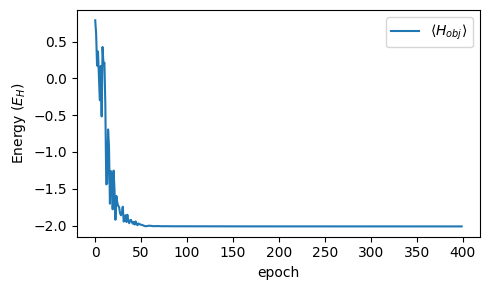

In [7]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

y = energies 
ax.plot(y, label="$\\langle H_{{obj}}\\rangle$")
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle$")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
# ax.set_yscale("log")
ax.set_ylabel("Energy ($E_H$)")
ax.set_xlabel("epoch")
ax.legend()

plt.tight_layout()
plt.show()

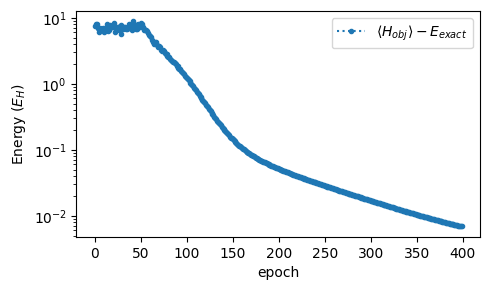

In [10]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

y = energies - e_ground_state_exact
ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Energy ($E_H$)")
ax.set_xlabel("epoch")
ax.legend()

plt.tight_layout()
plt.show()

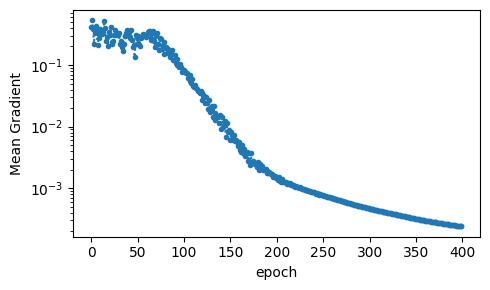

In [11]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = mean_gradients
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Mean Gradient")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

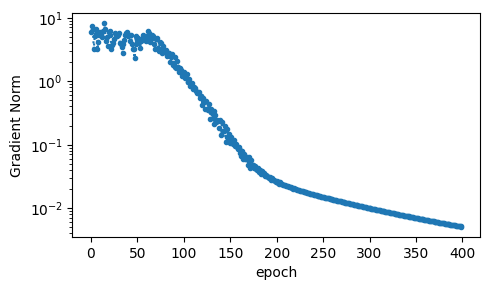

In [12]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = [jnp.linalg.norm(gradient) for gradient in gradients_trajectory]
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Gradient Norm")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

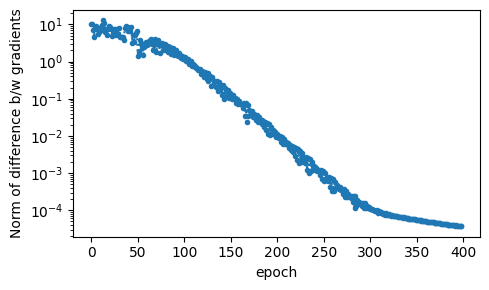

In [13]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = [jnp.linalg.norm(gradients_trajectory[j] - gradients_trajectory[j-1]) for j in range(1,len(gradients_trajectory))]
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Norm of difference b/w gradients")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

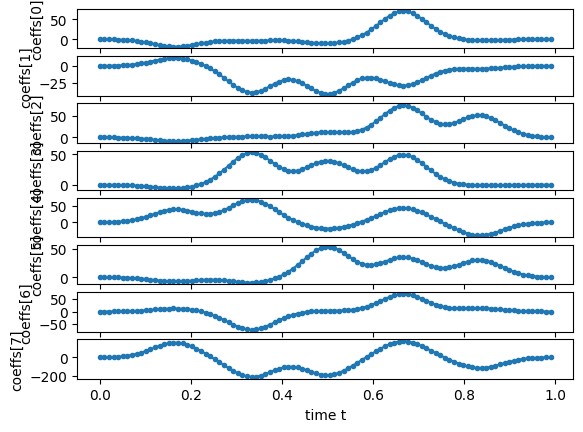

In [20]:
ts = jnp.linspace(0.0, 1, 100)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, sharex=True)
for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-")
    ax.set_ylabel(f"coeffs[{i}]")
ax.set_xlabel("time t")
plt.show()

In [21]:
# Calculating the Final Hessian

final_hessian = jax.jacrev(jax.jacrev(loss))(param_vector)
final_hessian_eigenvalues = jnp.linalg.eigvals(final_hessian)
final_hessian_eigenvalues

Array([ 3.14075158e+01+0.00000000e+00j,  2.51661197e+01+0.00000000e+00j,
        2.15380501e+01+0.00000000e+00j,  1.66529912e+01+0.00000000e+00j,
        1.51514626e+01+0.00000000e+00j,  1.33480071e+01+0.00000000e+00j,
        1.06508583e+01+0.00000000e+00j,  9.13305698e+00+0.00000000e+00j,
        7.40277027e+00+0.00000000e+00j,  5.26620397e+00+0.00000000e+00j,
        4.97771034e+00+0.00000000e+00j,  4.91903990e+00+0.00000000e+00j,
        8.32700270e-01+0.00000000e+00j,  8.11341107e-01+0.00000000e+00j,
        5.08798284e-01+0.00000000e+00j,  8.48426780e-02+0.00000000e+00j,
        4.74372988e-02+0.00000000e+00j,  3.88260319e-02+0.00000000e+00j,
        3.71597041e-02+0.00000000e+00j,  1.25641211e-02+0.00000000e+00j,
        5.85452090e-03+0.00000000e+00j,  4.69569204e-03+0.00000000e+00j,
        2.79050233e-03+0.00000000e+00j,  2.08669075e-03+0.00000000e+00j,
        1.76265177e-03+0.00000000e+00j, -1.25322564e-03+0.00000000e+00j,
        1.44400623e-03+0.00000000e+00j,  1.10923230

/Users/jorgegarciaponce/Research/Yelin/PerceptronLossLandscapes/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


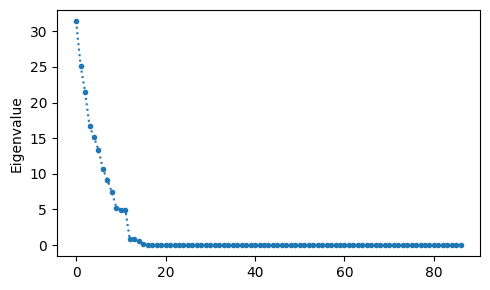

In [22]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = np.linalg.eigvals(final_hessian)

# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
# ax.set_yscale("log")
ax.set_ylabel("Eigenvalue")
# ax.set_xlabel("Eigenvalue")
# ax.legend()

plt.tight_layout()
plt.show()